# On the Validation of HDBSCAN


Clustering is a very hard problem because there is never truly a 'right' answer when labels do not exist.

This is compounded by techniques with various assumptions in place. If a technique is run incorrectly, violating an assumption, this leads to incorrect (dead wrong) results.

In this blogpost, we will delve a bit into why clustering gets complicated, and then take a dive deep on how to properly tune density-based clusters in [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan).

*Note: Updated 11/2023 - the order of this Notebook is changed because DensClus convereges to the optimal metric value given the hyperparameters. We now first tune and then call DenseClus. 


## Background: Clustering is Complicated

There is [No Free Lunch](https://en.wikipedia.org/wiki/No_free_lunch_theorem) for clustering algorithms and while one algorithm might fit a certain dataset well, there are no guarantees that it will work on a different dataset in the exact same manner. Likewise, clustering is "strongly dependent on contexts, aims and decisions of the researcher" which adds fire to the argument that there is no such thing as a "universally optimal method that will just produce natural clusters" as noted by Henning in [What Are True Clusters? Henning 2015](https://arxiv.org/abs/1502.02555).

For example, commonly used techniques such as KMeans, assume that data is numerical and sphere-shaped. Those types of assumptions do not fair well when the data has high dimensionality and includes categorical values. 

Cluster data that is in violation of assumptions causes a conundrum for the practitioner in two ways: 

1) How to formalize a specific featurization scheme?
2) What clustering technique to choose? 

Both of these must be formulated so that no assumptions are violated. In practice,  this can lead to a process of elimination whereby the algorithm and featurization scheme that don’t violate an algorithm's assumptions is the only choice standing.

## Be Wary of Your Metric

When no labels are available it's common to pick a objective metric such as [Silhouette Score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) to evaluate and then decide on the final clustering result. Silhouette Score measures cluster cohesiveness and separation with an index between -1 to 1. It does *NOT* take into account noise in the index calculation and makes use of distances. Distance is not applicable for a density-based technique. Not including a noise in the objective metric calculation violates an inherent assumption in density-based clustering.

**This means that Silhouette Score and similar indexes like it are inappropriate for measuring density-based techniques!!!**
(my own emphasis added because I've seen multiple blogs on here doing it - this is dangerous.)


## Density Based Clustering Validation to the Rescue

Density Based Clustering Validation or DBCV works for desnity-based clustering algorithms precisely because it takes noise into account and captures the shape property of clusters via densities and not distances (see the [original paper](https://www.dbs.ifi.lmu.de/~zimek/publications/SDM2014/DBCV.pdf))

As the paper explains, the final result of DBCV is a weighted sum of “Validity Index” values of clusters. This produces a score between -1 to 1, with the larger the value the better clustering solution.

Source: Density-Based Clustering Validation, Moulavi et al. 2014

An in depth discussion is out scope here but please see the original paper for more details.

Note that DBCV does have [drawbacks](https://github.com/scikit-learn-contrib/hdbscan/issues/283). Like all other metrics and techniques DBCV is not immune from the problems of complication and measurement in clustering as noted earlier.

However, outside of having groundtruth labels it provides an objective criteria from which to judge how well-separated density-based technique clusters are.

## Example

Enough of that, let's dive into a real example. 

The [notebook](https://github.com/awslabs/amazon-denseclus/blob/main/notebooks/Tuning%20with%20HDBSCAN.ipynb) is available within the [Amazon Denseclus library](https://github.com/awslabs/amazon-denseclus).

In this example, you will use a synthetic churn dataset for an imaginary telecommunications company with the outcome Churn? flagged as as either True (churned) or False (did not churn). Features include customer details such as plan and usage information. The churn dataset is publicly available and mentioned in the book [Discovering Knowledge in Data by Daniel T. Larose](https://www.amazon.com/dp/0470908742/). It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.

The data includes both numeric and categorical features but will use Denseclus to transform it into lower-dimensional, dense space to form clusters on. For more DenseClus [see here](https://aws.amazon.com/blogs/opensource/introducing-denseclus-an-open-source-clustering-package-for-mixed-type-data/). All of the need transformations are taken care of under the hood. You just get to call `fit`.

In [1]:
%pip install matplotlib seaborn -q
%pip install --upgrade ipywidgets -q
%pip install --upgrade jupyter -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import logging  # to further silence deprecation warnings
import warnings

import hdbscan
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hdbscan.validity import validity_index
from sklearn import metrics, preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

# This runs in about a minute or two
from denseclus import DenseClus

warnings.filterwarnings("ignore")

%matplotlib inline

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})


SEED = 42
np.random.seed(SEED)  # set the random seed to reproduce results as best we can
# see: https://umap-learn.readthedocs.io/en/latest/reproducibility.html

data_url = (
    "https://raw.githubusercontent.com/awslabs/aws-customer-churn-pipeline/main/data/churn.txt"
)
df = pd.read_csv(data_url)

df.drop(["Phone", "Area Code"], axis=1, inplace=True)

df.head(5)

,State,Account Length,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,PA,163,no,yes,300,8.162204,3,7.579174,3.933035,4,6.508639,4.065759,100,5.111624,4.928160,6,5.673203,3,True.
1,SC,15,yes,no,0,10.018993,4,4.226289,2.325005,0,9.972592,7.141040,200,6.436188,3.221748,6,2.559749,8,False.
2,MO,131,no,yes,300,4.708490,3,4.768160,4.537466,3,4.566715,5.363235,100,5.142451,7.139023,2,6.254157,4,False.
3,WY,75,yes,yes,700,1.268734,3,2.567642,2.528748,5,2.333624,3.773586,450,3.814413,2.245779,6,1.080692,6,False.
4,WY,146,yes,no,0,2.696177,3,5.908916,6.015337,3,3.670408,3.751673,250,2.796812,6.905545,4,7.134343,6,True.


## Hyperparameter Tuning

The two primary hyperparameters to look at to further improve results are `min_samples` and `min_cluster_size`, as noted in the [HDBSCAN documentation](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html).

You will run multiple combinations of these to find a result that generates high DBCV score.

In addition to looking at these hyperparameters you will also look at cluster selection methods with Expectation of Mass eom and splitting clusters along the tree with leaf (for details see hdbscan: Hierarchical density based clustering In, McInnes, J. Healy, S. Astels 2017).

As HDBSCAN's documentation notes, whereas the eom method only extracts the most stable, condensed clusters from the tree, the leaf method selects clusters from the bottom of the leaf nodes as well.

This results in smaller, more homogeneous clusters that are more likely to be fine grained.

In [22]:
# Fit a UMAP to the data to cluster on
numerics_df = df.select_dtypes(include=[int, float])

fitted_umap = umap.UMAP(n_components=5, n_neighbors=30, min_dist=0.0).fit(numerics_df)

In [20]:
# we will make our own scorer for DBCV


def dbcv_score(X, labels):
    return validity_index(X, labels)


dbcv_scorer = make_scorer(dbcv_score, greater_is_better=True)

logging.captureWarnings(True)

# specify parameters and distributions to sample from
param_distributions = {
    "min_samples": [10, 30, 50, 60, 100],
    "min_cluster_size": [100, 200, 300, 400, 500, 600],
    "cluster_selection_method": ["eom", "leaf"],
    "metric": ["euclidean", "manhattan"],
}

n_iter_search = 50
random_search = RandomizedSearchCV(
    hdb,
    param_distributions=param_distributions,
    n_iter=n_iter_search,
    scoring=dbcv_scorer,
    random_state=SEED,
)

random_search.fit(fitted_umap.embedding_)

print(f"Best Parameters {random_search.best_params_}")
print(f"DBCV score :{random_search.best_estimator_.relative_validity_}")

Best Parameters {'min_samples': 100, 'min_cluster_size': 300, 'metric': 'manhattan', 'cluster_selection_method': 'eom'}
DBCV score :0.2796430582890555


Pretty good but can we do better?

DenseClus will allow us to use the categorical features and converge to a better outcome because of it.

In [14]:
logging.captureWarnings(True)

clf = DenseClus(random_state=SEED, umap_combine_method="intersection")

clf.fit(df)

Max of 51 is greater than threshold 25
Hashing categorical features


Under the hood, among other steps, Denseclus uses HDBSCAN to cluster the data.

Let's look at the how the data got split.

In [29]:
embedding = clf.mapper_.embedding_
labels = clf.score()
clustered = labels >= 0

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ["cluster", "count"]
print(cnts.sort_values(["cluster"]))

   cluster  count
1        0   1253
3        1   1239
2        2   1250
0        3   1258


Upon examination there are exactly 4 almost evenly distributed clusters with -1 representing the noise found in the data.

In addition, to simply looking at their spread, another way to evaluate clusters it to visualize them.

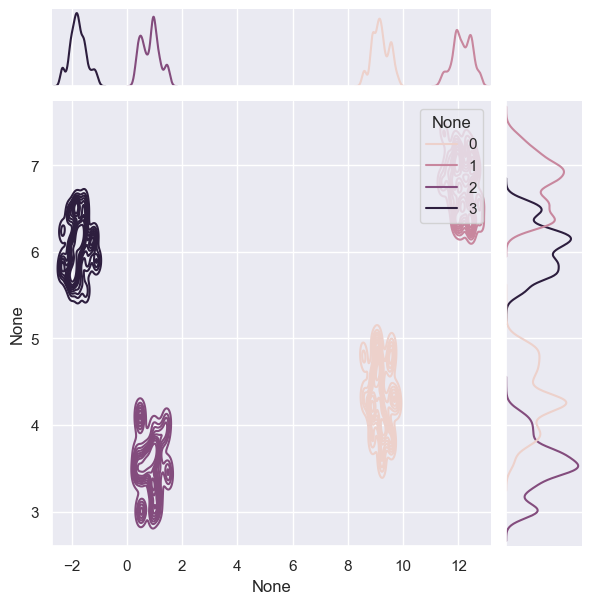

In [30]:
_ = sns.jointplot(
    x=embedding[clustered, 0], y=embedding[clustered, 1], hue=labels[clustered], kind="kde"
)

As you can see we have 4 distinct islands formed within this slice of the data. Clusters have formed around these densities which is exactly the behavior we expect DenseClus to do.

You can further confirm the outcome by plotting the tree along which the densities were split.

This is a graphical view of the counts we saw with more information. For example, you can see that a two cluster solution is also possible as two densities represent the base split for the clusters.

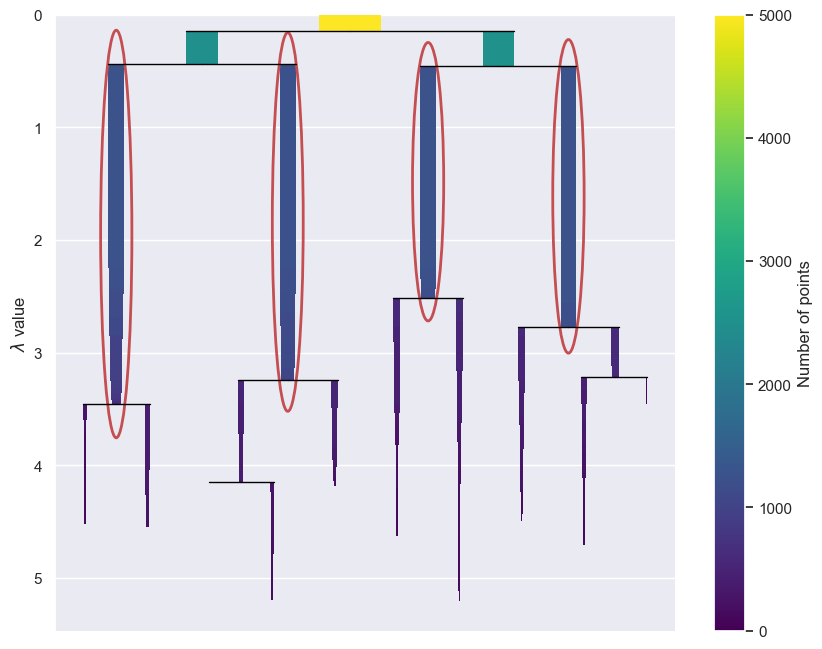

In [25]:
_ = clf.hdbscan_.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(clustered).shape[0]),
)

Lastly, let's confirm that the majority of data points are covered by our clusters and the DBCV score.

In [26]:
coverage = np.sum(clustered) / embedding.shape[0]

print(f"Coverage {coverage}")
print(f"DBCV score {clf.hdbscan_.relative_validity_}")

Coverage 1.0
DBCV score 0.7532237746488655


The DBCV comes between a scale of -1 to 1.

In practice we would want a score over 0.45 to make sure that clusters are well-separated.

## Conclusion

I hoped you enjoyed a closer look at how to tune hyperparameters for HDBSCAN!!!

In this post you looked at why clustering and clustering metrics can get complicated, you then learned about DBCV as an objective metric, and you then applied it using Amazon Denseclus and HDBSCAN.

We've only scrapped the surface here. To dive deeper you could look at the following:

* What other type of optimization frameworks can you use in place of Random Search?
* What other type of hyperparameters are possible to use for tuning?
* What other measures are possible here for further cluster validation?
* Can any other underlying hyperparameters in Denseclus be tweaked to achieve a higher score?


## References

*"Silhouettes: a Graphical Aid to the Interpretation and Validation of Cluster Analysis"*, Rousseeuw 1987

*"Density-Based Clustering Validation"*, Moulavi et al. 2014

*"hdbscan: Hierarchical density based clustering In"*, McInnes, J. Healy, S. Astels 2017